The aim of this notebook is to use PCA to explore whether there is a difference between the animal and non-animal dataset somewhere in the activations of LLama 7B 2 chat, and to identify where this difference is. 

In [1]:
import numpy as np
import random
import pandas as pd
import torch as t
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:64'

import utils
%%autoreload

/Users/paul/anaconda3/envs/acd/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load model and dataset
model = utils.HookedModel("openai-community/gpt2")
dataset = utils.Dataset()
dataset.load_data('../datasets/ilikecats_20000.csv', 'Animal', 'Non-Animal')

In [3]:
# Collect activations for last tokens
num_samples = 128
batch_size = 8
layers = model.model.transformer.h[:]
max_length = None

pos_dataset, neg_dataset = dataset.get_subset_sentences(num_samples)

animal_activations = model.get_last_token_activations(pos_dataset, layers, max_tokens = max_length, batch_size = batch_size)
non_animal_activations = model.get_last_token_activations(neg_dataset, layers, max_tokens = max_length, batch_size = batch_size)

In [4]:
animal_detection_vectors = utils.compute_direction_vectors(animal_activations, non_animal_activations)

In [5]:
# Compute animal direction for each layer

# Get layer names. Will depend on model!
layer_names = [f'Layer_{i}' for i in range(0,len(model.model.transformer.h))] # Max is range(len(model.transformer.h)

# Shorten samples, create train-test split

num_examples = 1000 # print(len(animal_sentences))

animal_sentences = dataset.pos_dataset
non_animal_sentences = dataset.neg_dataset

animal_sentences_short = animal_sentences[0:num_examples]
non_animal_sentences_short = non_animal_sentences[0:num_examples]

train_test_split = 0.8

train_animal_sentences = animal_sentences_short[0:int(num_examples*0.8)]
test_animal_sentences = animal_sentences_short[int(num_examples*0.8):]

train_non_animal_sentences = non_animal_sentences_short[0:int(num_examples*0.8)]
test_non_animal_sentences = non_animal_sentences_short[int(num_examples*0.8):]

# Compute activation directions



In [6]:
# Use test set to find values of projections of animanl and non-animal sentences onto animal directions.
# Plot accuracy
test_data = test_animal_sentences + test_non_animal_sentences
labels = [1]*len(test_animal_sentences) + [0]*len(test_non_animal_sentences)
test_activations = model.get_last_token_activations(test_data, layers, max_tokens = max_length, batch_size = batch_size)

accuracies = {}

In [7]:
print(test_activations['Layer_1'].shape)
print(animal_detection_vectors['Layer_1'].shape)

torch.Size([400, 768])
(768,)


torch.Size([400, 768])
(768,)
Accuracy for Layer_0: 0.5
torch.Size([400, 768])
(768,)
Accuracy for Layer_1: 0.5
torch.Size([400, 768])
(768,)
Accuracy for Layer_2: 0.5
torch.Size([400, 768])
(768,)
Accuracy for Layer_3: 0.52
torch.Size([400, 768])
(768,)
Accuracy for Layer_4: 0.8325
torch.Size([400, 768])
(768,)
Accuracy for Layer_5: 0.775
torch.Size([400, 768])
(768,)
Accuracy for Layer_6: 0.9325
torch.Size([400, 768])
(768,)
Accuracy for Layer_7: 0.825
torch.Size([400, 768])
(768,)
Accuracy for Layer_8: 0.8775
torch.Size([400, 768])
(768,)
Accuracy for Layer_9: 0.8925
torch.Size([400, 768])
(768,)
Accuracy for Layer_10: 0.8575
torch.Size([400, 768])
(768,)
Accuracy for Layer_11: 0.87


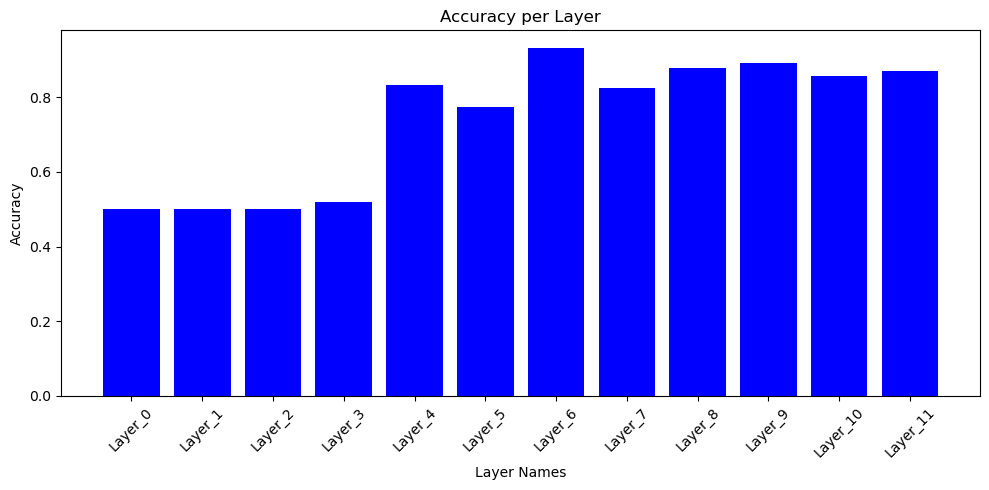

In [8]:


for layer_name in layer_names:
    accuracy = utils.calculate_accuracy(test_activations[layer_name], animal_detection_vectors[layer_name], labels)
    accuracies[layer_name] = accuracy
    print(f"Accuracy for {layer_name}:", accuracy)

# Plotting accuracies
plt.figure(figsize=(10, 5))
# layer_names_sorted = sorted(accuracies.keys())  # Optional: Sort layer names if needed
accuracy_values = [accuracies[name] for name in layer_names]
plt.bar(layer_names, accuracy_values, color='blue')
plt.xlabel('Layer Names')
plt.ylabel('Accuracy')
plt.title('Accuracy per Layer')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to make room for rotated x-axis labels
plt.show()